In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

%matplotlib inline

In [2]:
DATA_PATH = './data'
DF_NAME_2017 = '2017-data-for-consulates.csv'
DF_NAME_2018 = '2018-data-for-consulates.csv'
PATH_TO_SAVE = './Pictures/'

In [3]:
params = {'axes.titlesize':'x-large'}
pylab.rcParams.update(params)

In [4]:
df_2018 = pd.read_csv(os.path.join(DATA_PATH, DF_NAME_2018))
df_2018['year'] = 2018

In [5]:
df_2017 = pd.read_csv(os.path.join(DATA_PATH, DF_NAME_2017))
df_2017['year'] = 2017

In [6]:
df = df_2018.append(df_2017, ignore_index=True)

In [7]:
df = df.drop([col for col in df.columns if 'ATVs' in col], axis=1) # This type of visa we are not intrested in

In [8]:
rename_dict = {'Schengen State': 'schengen_state',
               'Country where consulate is located': 'consulate_country',
               'Consulate': 'consulate_city',
               'Uniform visas applied for': 'num_applications',
               'Total  uniform visas issued (including MEV) \n': 'uniform_visas_issued',
               'Multiple entry uniform visas (MEVs) issued': 'MEVs_issued',
               'Share of MEVs on total number of uniform visas issued': 'MEVs_share',
               'Total LTVs issued': 'LTVs_issued',
               'Uniform visas not issued': 'uniform_rejected',
               'Not issued rate for uniform visas': 'rejection_rate'}

In [9]:
df.rename(columns=rename_dict, inplace=True)

In [10]:
df.head(10)

,schengen_state,consulate_country,consulate_city,num_applications,uniform_visas_issued,MEVs_issued,MEVs_share,LTVs_issued,uniform_rejected,rejection_rate,year
0,Austria,ALBANIA,TIRANA,62,32,10,31.3%,21,9,14.5%,2018
1,Austria,ALGERIA,ALGIERS,2481,1658,1461,88.1%,1,822,33.1%,2018
2,Austria,ARGENTINA,BUENOS AIRES,16,16,16,100.0%,NaN,NaN,NaN,2018
3,Austria,AUSTRALIA,CANBERRA,2776,2653,989,37.3%,1,122,4.4%,2018
4,Austria,AZERBAIJAN,BAKU,1976,1895,1769,93.4%,2,79,4.0%,2018
5,Austria,BOSNIA AND HERZEGOVINA,SARAJEVO,616,615,615,100.0%,NaN,1,0.2%,2018
6,Austria,BRAZIL,BRASILIA,37,37,36,97.3%,NaN,NaN,NaN,2018
7,Austria,BULGARIA,SOFIA,217,199,162,81.4%,13,5,2.3%,2018
8,Austria,CANADA,OTTAWA,686,659,107,16.2%,1,26,3.8%,2018
9,Austria,CHILE,SANTIAGO DE CHILE,22,22,17,77.3%,NaN,NaN,NaN,2018


In [11]:
df.shape

(3797, 11)

In [12]:
df.isnull().sum()

schengen_state            26
consulate_country         26
consulate_city            20
num_applications          25
uniform_visas_issued     100
MEVs_issued              295
MEVs_share               299
LTVs_issued             1699
uniform_rejected         749
rejection_rate           752
year                       0
dtype: int64

In [13]:
df = df.dropna(axis=0, subset=['schengen_state', 'num_applications']).reset_index(drop=True) # Not interested in data where we don't know 'schengen_state' or 'num_applications'

In [14]:
df.isnull().sum()

schengen_state             0
consulate_country          0
consulate_city             0
num_applications           0
uniform_visas_issued      78
MEVs_issued              270
MEVs_share               272
LTVs_issued             1676
uniform_rejected         725
rejection_rate           725
year                       0
dtype: int64

В данных есть следующая проблема: некоторые числа записаны как "2,123": 

In [15]:
df.tail()

,schengen_state,consulate_country,consulate_city,num_applications,uniform_visas_issued,MEVs_issued,MEVs_share,LTVs_issued,uniform_rejected,rejection_rate,year
3761,Switzerland,USA,"ATLANTA, GA","1,405","1,394","1,380",99.0%,4,7,0.5%,2017
3762,Switzerland,USA,"NEW YORK, NY","3,187","3,116","3,109",99.8%,62,9,0.3%,2017
3763,Switzerland,USA,"SAN FRANCISCO, CA","2,675","2,662","2,624",98.6%,6,7,0.3%,2017
3764,Switzerland,USA,"WASHINGTON, DC","1,049",993,571,57.5%,29,27,2.6%,2017
3765,Switzerland,VIETNAM,HO CHI MINH,"3,643","3,355",408,12.2%,10,278,7.6%,2017


Следующая функция переводит такие строки в числа:

In [16]:
def str_to_int(df, columns):
    for col in columns:
        df.loc[~df[col].isnull(), col] = pd.Series(list(map(lambda x: int(x.replace(',','').replace('%', '').strip()), df[col][~df[col].isnull()].astype(str)))).values

In [17]:
str_to_int(df, columns=['num_applications', 'uniform_visas_issued', 'MEVs_issued','LTVs_issued', 'uniform_rejected'])

In [18]:
df.isnull().sum()

schengen_state             0
consulate_country          0
consulate_city             0
num_applications           0
uniform_visas_issued      78
MEVs_issued              270
MEVs_share               272
LTVs_issued             1676
uniform_rejected         725
rejection_rate           725
year                       0
dtype: int64

### Количество заявок на получение визы по странам

In [19]:
threshold = 500000

In [20]:
df_groupby_state_apps_2017 = df.groupby(['year', 'schengen_state']).sum().loc[2017]
df_groupby_state_apps_2017.loc['Other', 'num_applications'] = df_groupby_state_apps_2017.num_applications[(df_groupby_state_apps_2017.num_applications < threshold)].sum()
df_groupby_state_apps_2017 = df_groupby_state_apps_2017.sort_values(by='num_applications')

df_groupby_state_apps_2018 = df.groupby(['year', 'schengen_state']).sum().loc[2018]
df_groupby_state_apps_2018.loc['Other', 'num_applications'] = df_groupby_state_apps_2018.num_applications[(df_groupby_state_apps_2017.num_applications < threshold)].sum()
df_groupby_state_apps_2018 = df_groupby_state_apps_2018.sort_values(by='num_applications')

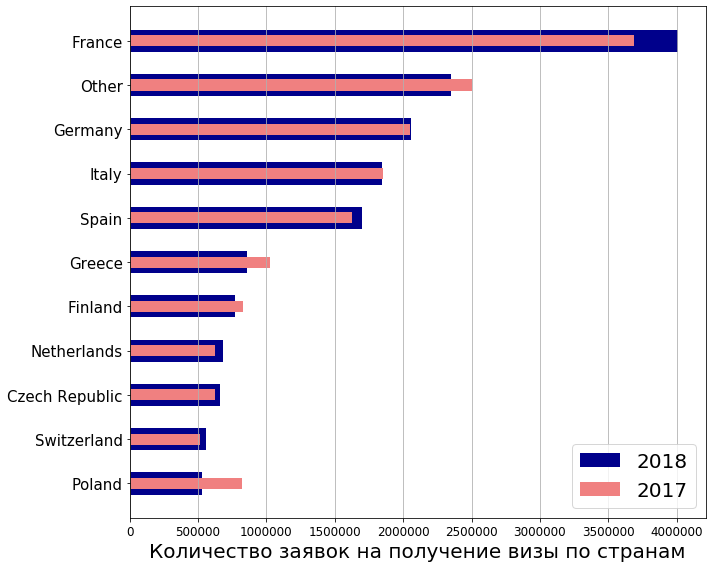

In [21]:
plt.figure(figsize=(10,8))
plt.barh(df_groupby_state_apps_2018[df_groupby_state_apps_2018.num_applications > threshold].index, df_groupby_state_apps_2018[df_groupby_state_apps_2018.num_applications > threshold].num_applications, height=0.5, color='darkblue', label='2018')
plt.barh(df_groupby_state_apps_2017[df_groupby_state_apps_2017.num_applications > threshold].index, df_groupby_state_apps_2017[df_groupby_state_apps_2017.num_applications > threshold].num_applications, height=0.25, color='lightcoral', label='2017')
plt.xlabel('Количество заявок на получение визы по странам', fontsize=20)
plt.legend()
plt.axis('tight')
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=15)
plt.gca().xaxis.grid(True)
plt.tight_layout()
plt.legend(loc=4, prop={'size': 20})
#plt.savefig(os.path.join(PATH_TO_SAVE, 'amount_per_country.png'), quality=100, format='png', dpi=500)
plt.show()

#### А в России?

In [22]:
df_russia = df[df.consulate_country == 'RUSSIAN FEDERATION']
threshold = 100000

In [23]:
df_russia_groupby_state_apps_2017 = df_russia.groupby(['year', 'schengen_state']).sum().loc[2017]
df_russia_groupby_state_apps_2017.loc['Other', 'num_applications'] = df_russia_groupby_state_apps_2017.num_applications[(df_russia_groupby_state_apps_2017.num_applications < threshold)].sum()
df_russia_groupby_state_apps_2017 = df_russia_groupby_state_apps_2017.sort_values(by='num_applications')

df_russia_groupby_state_apps_2018 = df_russia.groupby(['year', 'schengen_state']).sum().loc[2018]
df_russia_groupby_state_apps_2018.loc['Other', 'num_applications'] = df_russia_groupby_state_apps_2018.num_applications[(df_russia_groupby_state_apps_2017.num_applications < threshold)].sum()
df_russia_groupby_state_apps_2018 = df_russia_groupby_state_apps_2018.sort_values(by='num_applications')

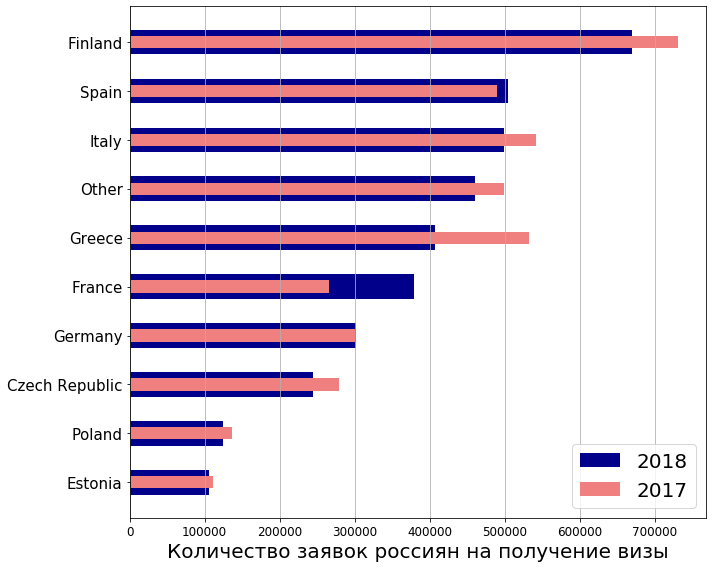

In [24]:
plt.figure(figsize=(10,8))
plt.barh(df_russia_groupby_state_apps_2018[df_russia_groupby_state_apps_2018.num_applications > threshold].index, df_russia_groupby_state_apps_2018[df_russia_groupby_state_apps_2018.num_applications > threshold].num_applications, height=0.5, color='darkblue', label='2018')
plt.barh(df_russia_groupby_state_apps_2017[df_russia_groupby_state_apps_2017.num_applications > threshold].index, df_russia_groupby_state_apps_2017[df_russia_groupby_state_apps_2017.num_applications > threshold].num_applications, height=0.25, color='lightcoral', label='2017')
plt.xlabel('Количество заявок россиян на получение визы', fontsize=20)
plt.legend()
plt.axis('tight')
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=15)
plt.gca().xaxis.grid(True)
plt.tight_layout()
plt.legend(loc=4, prop={'size': 20})
#plt.savefig(os.path.join(PATH_TO_SAVE, 'amount_per_country_russia.png'), quality=100, format='png', dpi=500)
plt.show()

#### Питер и все остальные города по заявкам в Финляндию

In [25]:
df_russia_groupby_city_fin = df_russia.groupby(['schengen_state', 'year', 'consulate_city']).sum().loc['Finland']

In [26]:
df_russia_groupby_city_fin

num_applications
year consulate_city                  
2017 MOSCOW                     70718
     MURMANSK                   27636
     PETROZAVODSK               41058
     ST. PETERSBURG            591581
2018 MOSCOW                     72955
     MURMANSK                   22590
     PETROZAVODSK               32413
     ST. PETERSBURG            541080

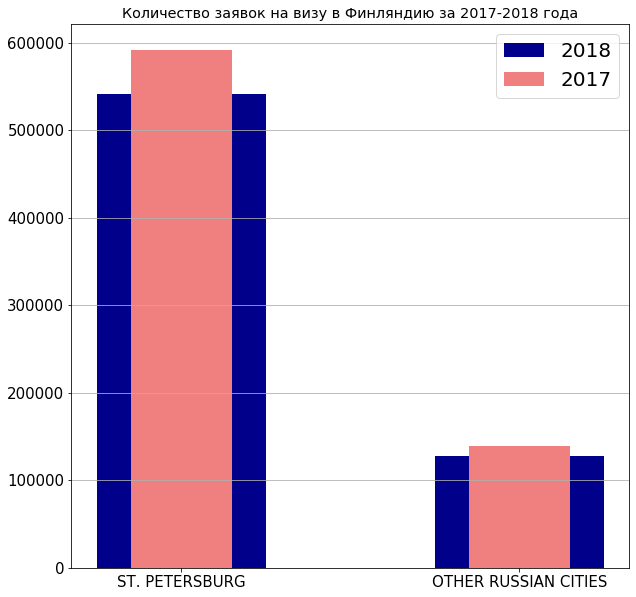

In [27]:
plt.figure(figsize=(10,10))
plt.gca().yaxis.grid(True)
plt.bar(['ST. PETERSBURG', 'OTHER RUSSIAN CITIES'], [df_russia_groupby_city_fin.loc[2018].num_applications['ST. PETERSBURG'], df_russia_groupby_city_fin.loc[2018].num_applications[df_russia_groupby_city_fin.loc[2018].index[:3]].sum()], width=0.5, color='darkblue', label='2018')
plt.bar(['ST. PETERSBURG', 'OTHER RUSSIAN CITIES'], [df_russia_groupby_city_fin.loc[2017].num_applications['ST. PETERSBURG'], df_russia_groupby_city_fin.loc[2017].num_applications[df_russia_groupby_city_fin.loc[2017].index[:3]].sum()], width=0.3, color='lightcoral', label='2017')
plt.title('Количество заявок на визу в Финляндию за 2017-2018 года')
plt.xticks(rotation=0, fontsize=15)
plt.yticks(rotation=0, fontsize=15)
plt.legend(loc=1, prop={'size': 20})
#plt.savefig(os.path.join(PATH_TO_SAVE, 'spb_vs_all.png'), quality=100, format='png', dpi=500)
plt.show()

## Что можно делать с большим количеством пропусков?

Проверим гипотезу о равенстве num_applications = uniform_visas_issued + LTVs_issued + uniform_rejected на данных без пропусков:

In [28]:
df_wo_nans = df.dropna(how='any').reset_index(drop=True)
df_wo_nans.head()

,schengen_state,consulate_country,consulate_city,num_applications,uniform_visas_issued,MEVs_issued,MEVs_share,LTVs_issued,uniform_rejected,rejection_rate,year
0,Austria,ALBANIA,TIRANA,62,32,10,31.3%,21,9,14.5%,2018
1,Austria,ALGERIA,ALGIERS,2481,1658,1461,88.1%,1,822,33.1%,2018
2,Austria,AUSTRALIA,CANBERRA,2776,2653,989,37.3%,1,122,4.4%,2018
3,Austria,AZERBAIJAN,BAKU,1976,1895,1769,93.4%,2,79,4.0%,2018
4,Austria,BULGARIA,SOFIA,217,199,162,81.4%,13,5,2.3%,2018


In [47]:
df_wo_nans['expected_num_applications'] = (df_wo_nans.uniform_visas_issued + df_wo_nans.LTVs_issued + df_wo_nans.uniform_rejected).astype(int)

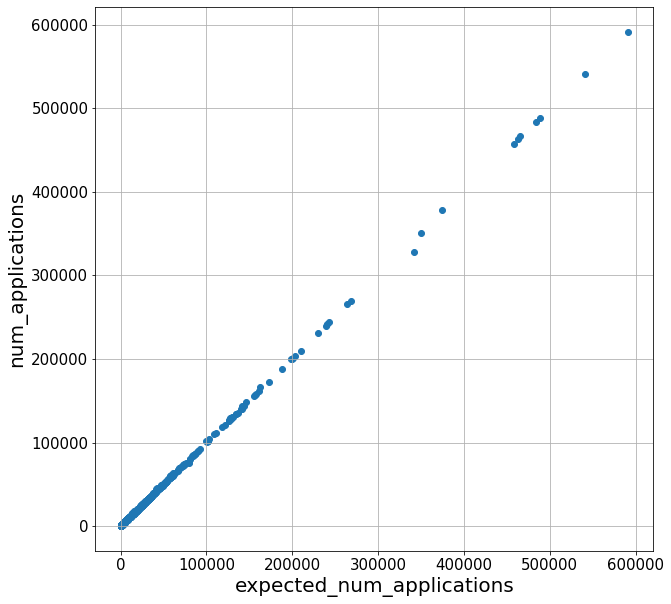

In [71]:
plt.figure(figsize=(10,10))
plt.scatter(df_wo_nans['expected_num_applications'], df_wo_nans.num_applications)
plt.ylabel('num_applications', fontsize=20)
plt.xlabel('expected_num_applications', fontsize=20)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(rotation=0, fontsize=15)
plt.grid()
plt.savefig(os.path.join(PATH_TO_SAVE, 'real_vs_expected_1.png'), quality=100, format='png', dpi=500)

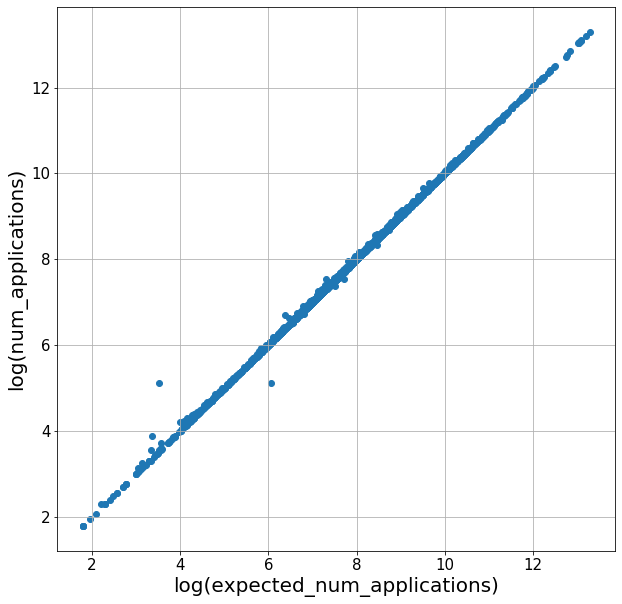

In [72]:
plt.figure(figsize=(10,10))
plt.scatter(np.log(df_wo_nans['expected_num_applications']), np.log(df_wo_nans.num_applications))
plt.ylabel('log(num_applications)', fontsize=20)
plt.xlabel('log(expected_num_applications)', fontsize=20)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(rotation=0, fontsize=15)
plt.grid()
plt.savefig(os.path.join(PATH_TO_SAVE, 'real_vs_expected_2.png'), quality=100, format='png', dpi=500)

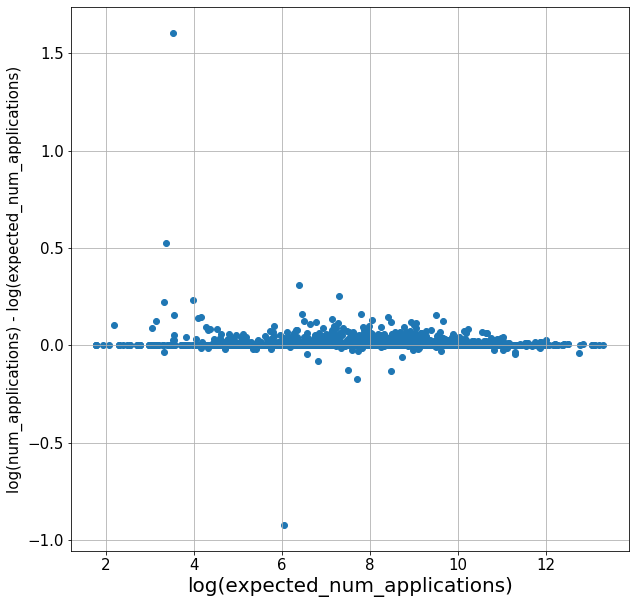

In [73]:
plt.figure(figsize=(10,10))
plt.scatter(np.log(df_wo_nans['expected_num_applications']), np.log(df_wo_nans.num_applications) - np.log(df_wo_nans['expected_num_applications']))
plt.xlabel('log(expected_num_applications)', fontsize=20)
plt.ylabel('log(num_applications) - log(expected_num_applications)', fontsize=15)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(rotation=0, fontsize=15)
plt.grid()
plt.savefig(os.path.join(PATH_TO_SAVE, 'real_vs_expected_3.png'), quality=100, format='png', dpi=500)

In [92]:
idx_outlier_max = np.array(np.log(df_wo_nans.num_applications) - np.log(df_wo_nans['expected_num_applications'])).argmax()

In [95]:
df_wo_nans.loc[idx_outlier_max]

schengen_state                    Sweden
consulate_country                 ISRAEL
consulate_city                  TEL AVIV
num_applications                     169
uniform_visas_issued                  31
MEVs_issued                            3
MEVs_share                          9.7%
LTVs_issued                            1
uniform_rejected                       2
rejection_rate                      1.2%
year                                2017
expected_num_applications             34
applications_actual-expected         135
Name: 1842, dtype: object

In [74]:
df_wo_nans['applications_actual-expected'] = df_wo_nans.num_applications - df_wo_nans.expected_num_applications

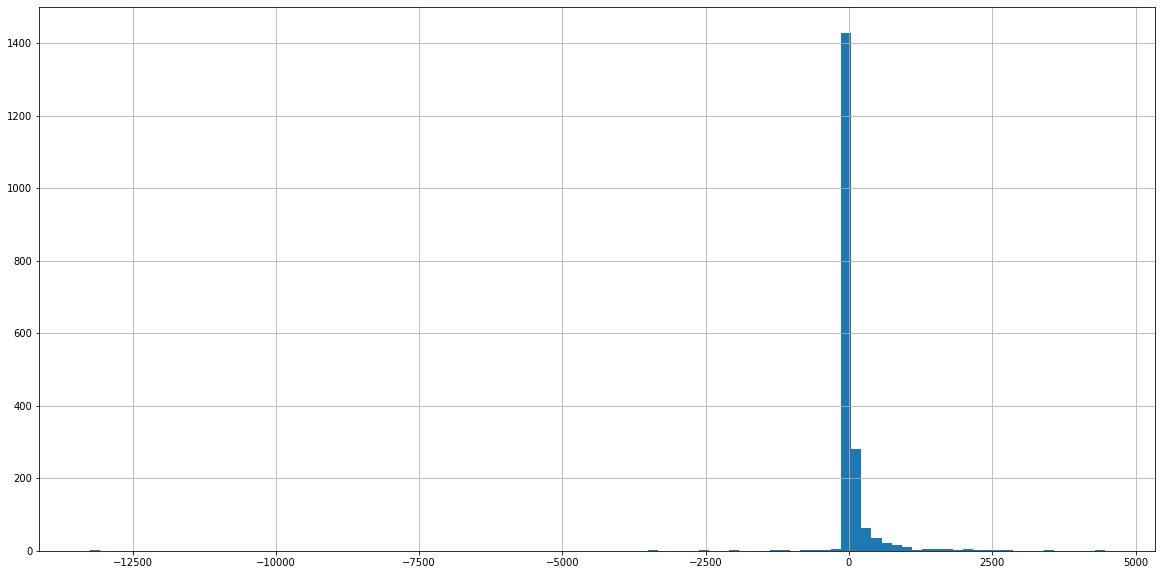

In [75]:
plt.figure(figsize=(20, 10))
df_wo_nans['applications_actual-expected'].hist(bins=100)

In [76]:
df_wo_nans['applications_actual-expected'].describe()

count     1907.000000
mean        74.264814
std        453.010724
min     -13240.000000
25%          0.000000
50%          0.000000
75%         33.000000
max       4462.000000
Name: applications_actual-expected, dtype: float64

In [82]:
needed_columns = [col for col in df_wo_nans.columns if col not in ['MEVs_issued', 'MEVs_share', 'year', 'consulate_city']]

In [83]:
df_wo_nans[df_wo_nans['applications_actual-expected'] == df_wo_nans['applications_actual-expected'].min()][needed_columns]

,schengen_state,consulate_country,num_applications,uniform_visas_issued,LTVs_issued,uniform_rejected,rejection_rate,expected_num_applications,applications_actual-expected
1141,France,ALGERIA,328475,213865,235,127615,38.9%,341715,-13240


In [20]:
def make_clips(data, name):
    return data[name].clip(lower=data[name].quantile(0.01), upper=data[name].quantile(0.99))

In [21]:
clipped_actual_minus_expected = make_clips(df_wo_nans, 'applications_actual-expected')

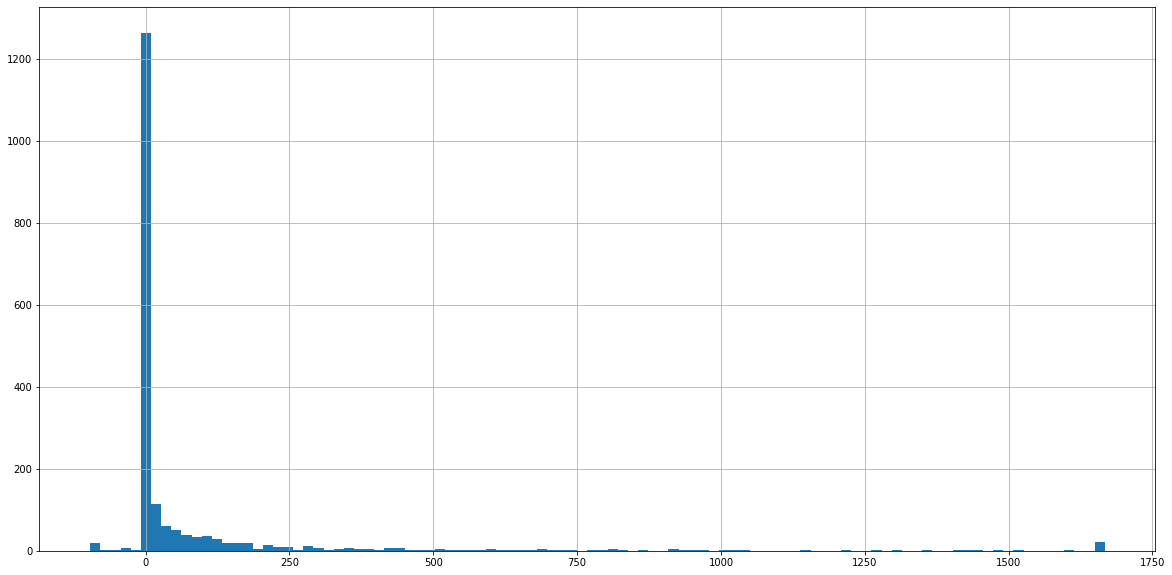

In [22]:
plt.figure(figsize=(20, 10))
clipped_actual_minus_expected.hist(bins=100)

## Попробуем заполнить пропуски (осмысленно!):

In [28]:
# красивая табличка для презентации
df_is_null = pd.DataFrame(index=df.columns)
df_is_null['Number of NaNs'] = df.isnull().sum().values
df_is_null = df_is_null.sort_values(by='Number of NaNs')
df_is_null

,Number of NaNs
schengen_state,0
consulate_country,0
consulate_city,0
num_applications,0
year,0
uniform_visas_issued,78
MEVs_issued,270
MEVs_share,272
uniform_rejected,725
rejection_rate,725


In [29]:
df.loc[df.num_applications == df.uniform_visas_issued, 'uniform_rejected'] = 0
df.loc[df.num_applications == df.uniform_visas_issued, 'LTVs_issued'] = 0
df.loc[df.num_applications == df.uniform_visas_issued, 'rejection_rate'] = '0%'

In [30]:
df.isnull().sum()

schengen_state             0
consulate_country          0
consulate_city             0
num_applications           0
uniform_visas_issued      78
MEVs_issued              270
MEVs_share               272
LTVs_issued             1278
uniform_rejected         325
rejection_rate           325
year                       0
dtype: int64

In [31]:
columns = ['uniform_visas_issued', 'LTVs_issued', 'uniform_rejected']
for col_1 in columns:
    for col_2 in columns:
        if col_1 != col_2:
            mask = (df[col_1] + df[col_2] == df['num_applications'])
            col_3 = [col for col in columns if col != col_1 and col != col_2][0]
            df.loc[mask & df[col_3].isnull(), col_3] = 0

In [39]:
df.loc[df.uniform_rejected == 0, 'rejection_rate'] = '0%'

In [40]:
df.isnull().sum()

schengen_state            0
consulate_country         0
consulate_city            0
num_applications          0
uniform_visas_issued     74
MEVs_issued             270
MEVs_share              272
LTVs_issued             643
uniform_rejected        218
rejection_rate          218
year                      0
dtype: int64

In [41]:
# красивая табличка для презентации
df_is_null_new = pd.DataFrame(index=df.columns)
df_is_null_new['Number of NaNs'] = df.isnull().sum().values
df_is_null_new = df_is_null_new.sort_values(by='Number of NaNs')
df_is_null_new

,Number of NaNs
schengen_state,0
consulate_country,0
consulate_city,0
num_applications,0
year,0
uniform_visas_issued,74
uniform_rejected,218
rejection_rate,218
MEVs_issued,270
MEVs_share,272


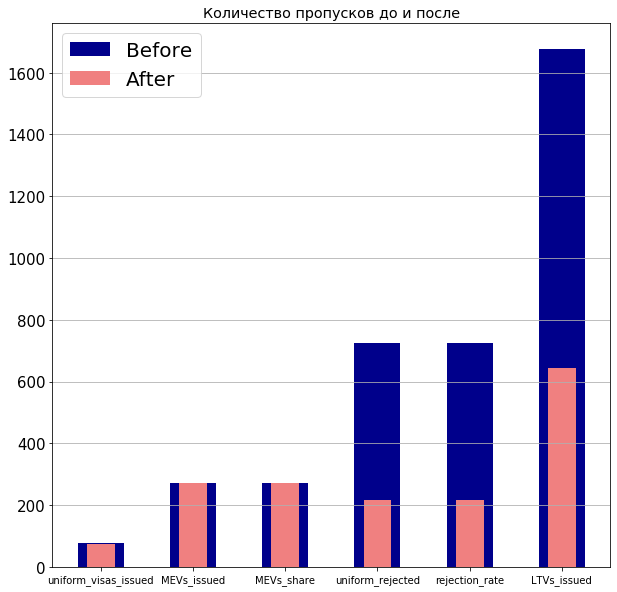

In [46]:
plt.figure(figsize=(10,10))
plt.gca().yaxis.grid(True)
plt.bar(df_is_null[df_is_null['Number of NaNs']>0].index, df_is_null.loc[df_is_null['Number of NaNs']>0, 'Number of NaNs'], width=0.5, color='darkblue', label='Before')
plt.bar(df_is_null_new[df_is_null_new['Number of NaNs']>0].index, df_is_null_new.loc[df_is_null_new['Number of NaNs']>0, 'Number of NaNs'], width=0.3, color='lightcoral', label='After')
plt.title('Количество пропусков до и после')
plt.xticks(rotation=0, fontsize=10)
plt.yticks(rotation=0, fontsize=15)
plt.legend(loc=2, prop={'size': 20})
plt.savefig(os.path.join(PATH_TO_SAVE, 'misses_before_after.png'), quality=100, format='png', dpi=500)
plt.show()

## Топ стран по отношению количества одобренных виз к количеству заявок по всем консульствам

In [29]:
df['uniform_acceptance_rate'] = df['uniform_visas_issued'] / df['num_applications']

In [30]:
df_acceptance_rate = df[~df['uniform_acceptance_rate'].isnull()]
#df_acceptance_rate['uniform_acceptance_rate'] = df_acceptance_rate['uniform_acceptance_rate'].astype(float)

In [32]:
df_acceptance_rate['uniform_acceptance_rate'] = df_acceptance_rate['uniform_acceptance_rate'].astype(float)

/home/mamat/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [51]:
df_acceptance_rate_mean = df_acceptance_rate.groupby(['schengen_state']).median()['uniform_acceptance_rate'].sort_values()

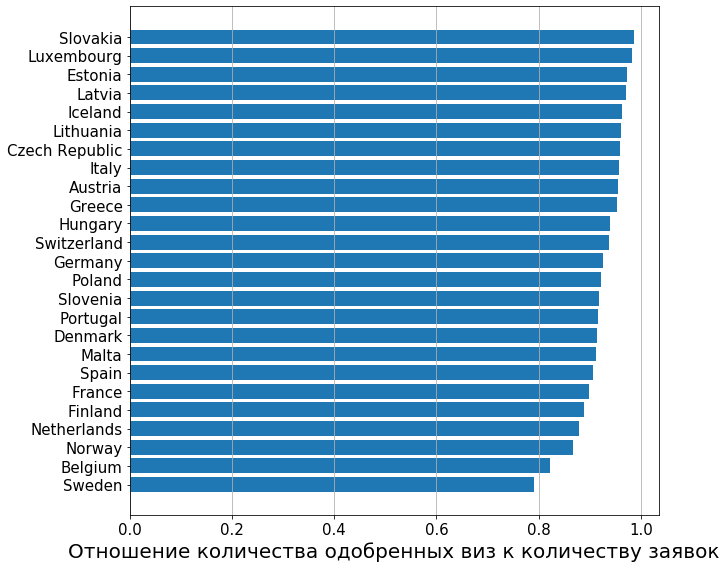

In [53]:
plt.figure(figsize=(10,8))
plt.barh(df_acceptance_rate_mean.index, df_acceptance_rate_mean.values)
plt.xlabel('Отношение количества одобренных виз к количеству заявок', fontsize=20)
plt.axis('tight')
#plt.xlim([0.5, 1])
plt.xticks(rotation=0, fontsize=15)
plt.yticks(rotation=0, fontsize=15)
plt.gca().xaxis.grid(True)
plt.tight_layout()
#plt.savefig(os.path.join(PATH_TO_SAVE, 'amount_per_country_russia.png'), quality=100, format='png', dpi=500)
plt.show()